<div style="color:yellow;">
<h2 style="font-weight:700">CS 4103 - Intelligent Systems</h2>
<h3>Hands-on Exercise - Normalization and Standardization</h3>
<h4>September 6, 2023</h4>
</div>

In [1]:
# import required libraries
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Loan Defaults Dataset
---
Anonymised Loan Default data, including loan amount, term, Interest rate, instalment, employment length, home ownership, annual income, loan status and purpose, etc. as well as the binary repay_fail (1 or 0).

Source: https://www.kaggle.com/datasets/joebeachcapital/loan-default

# Load and Preprocess Data

In [2]:
data = pd.read_csv('Anonymize_Loan_Default_data.csv',encoding='latin1', index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38480 entries, 2 to 38480
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38480 non-null  int64  
 1   member_id               38480 non-null  int64  
 2   loan_amnt               38479 non-null  float64
 3   funded_amnt             38479 non-null  float64
 4   funded_amnt_inv         38479 non-null  float64
 5   term                    38480 non-null  object 
 6   int_rate                38480 non-null  float64
 7   installment             38479 non-null  float64
 8   emp_length              37487 non-null  object 
 9   home_ownership          38480 non-null  object 
 10  annual_inc              38478 non-null  float64
 11  verification_status     38480 non-null  object 
 12  issue_d                 38480 non-null  object 
 13  loan_status             38480 non-null  object 
 14  purpose                 38480 non-null

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
2,2,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,RENT,0.0,Not Verified,Dec-99,Charged Off,major_purchase,000xx,ZZ,0.00,0.0,Jan-01,0.0,NaN,0.0,0.0,0.0,0.00%,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
3,545583,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,RENT,20004.0,Not Verified,Jul-10,Does not meet the credit policy. Status:Fully ...,other,487xx,MI,19.86,0.0,Aug-05,5.0,NaN,7.0,0.0,981.0,21.30%,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
4,532101,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,RENT,59000.0,Not Verified,Jun-10,Charged Off,debt_consolidation,115xx,NY,19.57,0.0,Apr-94,1.0,59.0,7.0,0.0,18773.0,99.90%,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
5,877788,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,MORTGAGE,53796.0,Not Verified,Sep-11,Fully Paid,other,751xx,TX,10.80,3.0,Mar-98,3.0,3.0,7.0,0.0,3269.0,47.20%,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
6,875406,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,RENT,30000.0,Not Verified,Sep-11,Fully Paid,debt_consolidation,112xx,NY,3.60,0.0,Jan-75,0.0,72.0,7.0,0.0,0.0,0%,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


# Data Preprocessing

In [5]:
# Drop columns that will not be used (dates, zip codes)
columns_to_drop = ['id','member_id', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line', 'next_pymnt_d', 'zip_code']
data = data.drop(columns_to_drop, axis=1)

# Drop rows with missing values
data.dropna(inplace=True)

# Get dataset size including target variable
print('Dataset shape:',data.shape)

# Convert percentage strings to numerical values
data['revol_util'] = data['revol_util'].str.strip('%').astype(float)

# Convert term to numerical values
data['term'] = data['term'].str.extract('(\d+)').astype(int)

# Convert emp_length to numerical values
data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype(float)

Dataset shape: (13779, 28)


In [6]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
4,5000.0,5000.0,5000.0,36,15.95,175.67,4.0,RENT,59000.0,Not Verified,Charged Off,debt_consolidation,NY,19.57,0.0,1.0,59.0,7.0,0.0,18773.0,99.9,15.0,2948.760000,2948.76,1909.02,873.81,175.67,1
5,7000.0,7000.0,7000.0,36,9.91,225.58,10.0,MORTGAGE,53796.0,Not Verified,Fully Paid,other,TX,10.80,3.0,3.0,3.0,7.0,0.0,3269.0,47.2,20.0,8082.391880,8082.39,7000.00,1082.39,1550.27,0
6,2000.0,2000.0,2000.0,36,5.42,60.32,10.0,RENT,30000.0,Not Verified,Fully Paid,debt_consolidation,NY,3.60,0.0,0.0,72.0,7.0,0.0,0.0,0.0,15.0,2161.663244,2161.66,2000.00,161.66,53.12,0
7,3600.0,3600.0,3600.0,36,10.25,116.59,10.0,MORTGAGE,675048.0,Not Verified,Does not meet the credit policy. Status:Fully ...,other,AL,1.55,0.0,4.0,25.0,8.0,0.0,0.0,0.0,25.0,4206.031191,4206.03,3600.00,606.03,146.75,0
11,19750.0,19750.0,19750.0,60,23.22,559.27,10.0,MORTGAGE,72500.0,Verified,Fully Paid,debt_consolidation,MO,19.96,0.0,0.0,61.0,15.0,0.0,21544.0,98.7,44.0,27544.891160,27544.89,19750.00,7794.89,15264.34,0


<h5 style="color:yellow">
Finish the remainder of the data preprocessing code by applying proper techniques in dealing with the rest of the categorical and numeric variables found in the dataset. For numerical values, include the column values that are converted in the cell above this. Refer to the first part of the code for the dataset's column info.
</h5>
<h5 style="color:lightblue">
Note: Exclude columns that will be dropped (shown above). <br>
Hint: You may recheck the data columns after execution of this initial preprocessing code.
</h5>

In [27]:
# Code for rest of the data preprocessing here
pdata = data.iloc[:, 0:-1].values
ydata = data.iloc[:, -1].values
le = LabelEncoder() # transform non-numerical data to numerical data
pdata[:, 7] = le.fit_transform(pdata[:, 7]) # home_ownership
pdata[:, 9] = le.fit_transform(pdata[:, 9]) # verification_status
pdata[:, 10] = le.fit_transform(pdata[:, 10]) #loan_status
pdata[:, 11] = le.fit_transform(pdata[:, 11]) # purpose
pdata[:, 12] = le.fit_transform(pdata[:, 12]) # addr_state


In [34]:
ydata

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

# Exploratory Data Analysis

<h5 style="color:yellow">
You may perform further analysis and data visualizations here aside from the ones given.
</h5>

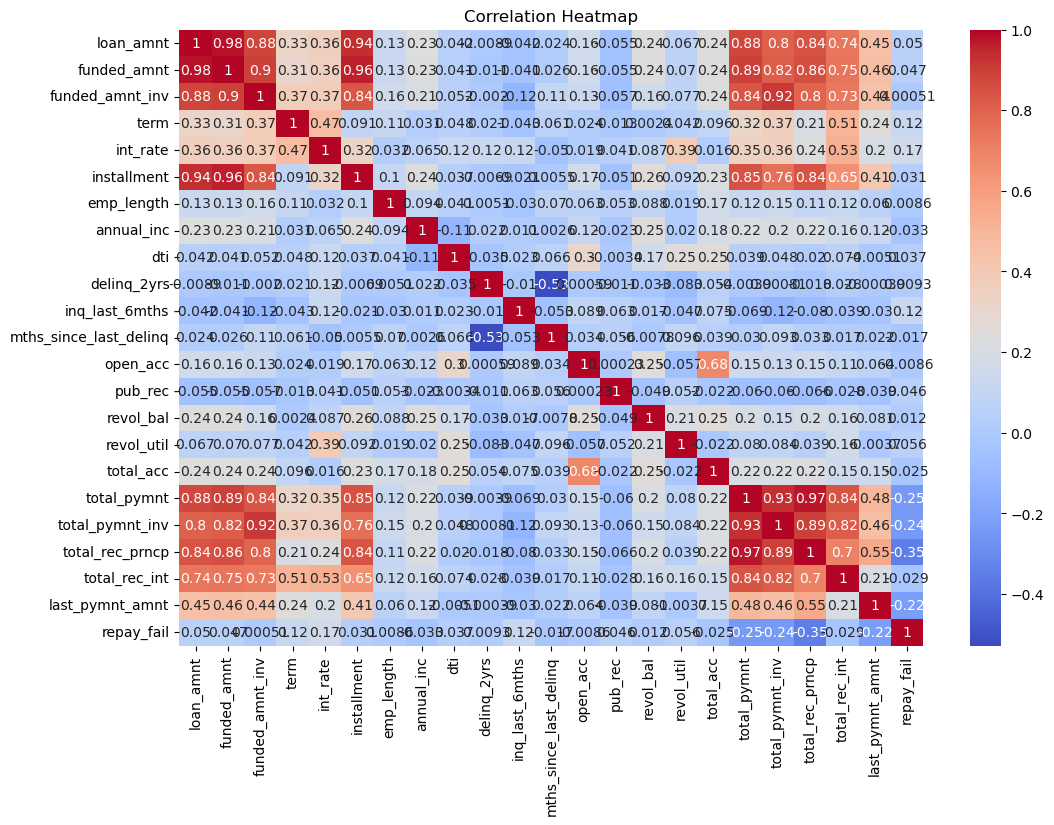

In [21]:
# Split the data into features (X) and target (y)
X = data
y = data['repay_fail']

# Explore correlations
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

X = X.drop('repay_fail', axis=1)

# Model Training and Evaluation

In [39]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pdata, ydata, test_size=0.2, random_state=42)

<h5 style="color:yellow">The code below uses Random Forest Classifier. Change the code and use neural networks instead to obtain the predictions.</h5>

In [44]:
# Initialize and train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print()
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.9990

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3449
           1       1.00      0.99      1.00       685

    accuracy                           1.00      4134
   macro avg       1.00      1.00      1.00      4134
weighted avg       1.00      1.00      1.00      4134



In [54]:
X_train

array([[15000.0, 15000.0, 15000.0, ..., 15000.0, 2148.99, 6903.59],
       [1450.0, 1450.0, 1450.0, ..., 1450.0, 122.3, 1186.63],
       [7000.0, 7000.0, 7000.0, ..., 7000.0, 2057.34, 258.77],
       ...,
       [4000.0, 4000.0, 3975.0, ..., 4000.0, 739.44, 136.54],
       [15000.0, 15000.0, 15000.0, ..., 15000.0, 4792.86, 11253.42],
       [12000.0, 12000.0, 12000.0, ..., 12000.0, 1801.89, 5566.97]],
      dtype=object)

In [55]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [56]:
# Initialize and train a RandomForestClassifier
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, activation='relu'),   # Input layer
    tf.keras.layers.Dense(units=6, activation='tanh'),   # Hidden layer
    tf.keras.layers.Dense(units=3, activation='tanh'),   # Input layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print('Model compiled!')


Model compiled!


In [57]:
ann.fit(X_train, y_train, batch_size = 1, epochs = 50)

Epoch 1/50
9645/9645 [==============================] - 15s 1ms/step - loss: 0.1544 - accuracy: 0.9461
Epoch 2/50
9645/9645 [==============================] - 16s 2ms/step - loss: 0.0254 - accuracy: 0.9917
Epoch 3/50
9645/9645 [==============================] - 14s 1ms/step - loss: 0.0161 - accuracy: 0.9952
Epoch 4/50
9645/9645 [==============================] - 14s 1ms/step - loss: 0.0141 - accuracy: 0.9959
Epoch 5/50
9645/9645 [==============================] - 14s 1ms/step - loss: 0.0131 - accuracy: 0.9968
Epoch 6/50
9645/9645 [==============================] - 13s 1ms/step - loss: 0.0120 - accuracy: 0.9966
Epoch 7/50
9645/9645 [==============================] - 14s 1ms/step - loss: 0.0110 - accuracy: 0.9969
Epoch 8/50
9645/9645 [==============================] - 14s 1ms/step - loss: 0.0110 - accuracy: 0.9969
Epoch 9/50
9645/9645 [==============================] - 14s 1ms/step - loss: 0.0106 - accuracy: 0.9974
Epoch 10/50
9645/9645 [==============================] - 14s 1ms/step - l